In [1]:
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')
from   GDa.session                    import session_info, session
from   GDa.spectral_analysis          import filtering, time_frequency
from   GDa.misc.create_grids          import create_stages_time_grid
from   GDa.graphics.plot_brain_sketch import plot_node_brain_sketch, plot_edge_brain_sketch
from   GDa.fc.lombardo                import lombardo
import numpy             as np
import matplotlib.pyplot as plt
import scipy
from   tqdm              import tqdm

#### Define stage and band names

In [2]:
stages      = ['baseline', 'cue', 'delay', 'match']
band_names  = [r'$\theta$', r'$\alpha$', r'$\beta$', r'low-$\gamma$ ', r'high-$\gamma$' ]

#### Auxiliary functions

In [3]:
# Auxiliary function to smooth
def smooth(x, w=5):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')

# Compute z-score of time series
def z_score(x):
    return (x-x.mean())/x.std()

def phase_locking_value(x, y):
    h1 = scipy.signal.hilbert(x)
    h2 = scipy.signal.hilbert(y)
    theta1 = np.unwrap(np.angle(h1))
    theta2 = np.unwrap(np.angle(h2))
    complex_phase_diff = np.exp(np.complex(0,1)*(theta1 - theta2))
    PLV = np.abs(np.sum(complex_phase_diff))/len(theta1)
    return PLV

def find_activation_sequences(spike_train):
    # make sure all runs of ones are well-bounded
    bounded = np.hstack(([0], spike_train, [0]))
    # get 1 at run starts and -1 at run ends
    difs    = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends,   = np.where(difs < 0)
    act_lengths =  run_ends - run_starts  # Length of each activation sequence
    return act_lengths
    
def count_activations(spike_train):
    act_lengths = find_activation_sequences(spike_train)
    if len(spike_train)==0:
        mu, sigma   = 0,0
        cv          = 0
    else:
        mu, sigma   = act_lengths.mean(), act_lengths.std()
        cv          = sigma/mu
    return mu, sigma, cv

### Instantiating session object

In [4]:
# Instantiate class|
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
              slvr_msmod = False, align_to = 'cue', trial_type = 1, \
              behavioral_response = 1, evt_dt = [-0.5, 2.5])
# Read data from .mat files
ses.read_from_mat()

In [5]:
# Frequency bands to use
bands = np.array([[4,8],
                  [8,15],
                  [15,40],
                  [40,70],
                  [70,100]])
# Downsample factor
delta = 30
# Time array
tarray = ses.readinfo['tarray'][::delta]
# Mask to track each stage of the ODRT
t_mask = create_stages_time_grid(ses.readinfo['t_cue_on'], ses.readinfo['t_cue_off'], ses.readinfo['t_match_on'], 
                                 ses.readinfo['fsample'], tarray, ses.readinfo['nT'])

### nFC

In [6]:
# Pairwise nodes' correlations
Cij = np.zeros([len(bands),
                ses.readinfo['pairs'].shape[0],
                ses.readinfo['nT'],
                tarray.shape[0]])
for j in tqdm(  range(len(bands)) ):
    # Filtered data
    f_data = filtering.bp_filter(data=ses.data, fs=ses.readinfo['fsample'], 
                                 f_low = bands[j][0], f_high=bands[j][1], n_jobs = -1)
    # Z-scoring data
    #Z = scipy.stats.zscore(f_data, axis=-1)[:,:,::delta]
    Z = scipy.stats.zscore(f_data, axis=-1)
    for i in range(ses.readinfo['nT']):
        for p in range(ses.readinfo['pairs'].shape[0]):
            #Cij[j,p,i,:] = Z[i,ses.readinfo['pairs'][p,0],:]*Z[i,ses.readinfo['pairs'][p,1],:]
            Cij[j,p,i,:] = lombardo(Z[i,ses.readinfo['pairs'][p,0],:], Z[i,ses.readinfo['pairs'][p,1],:], delta)

100%|██████████| 5/5 [02:23<00:00, 28.66s/it]


#### Links' correlation time series for a random trial

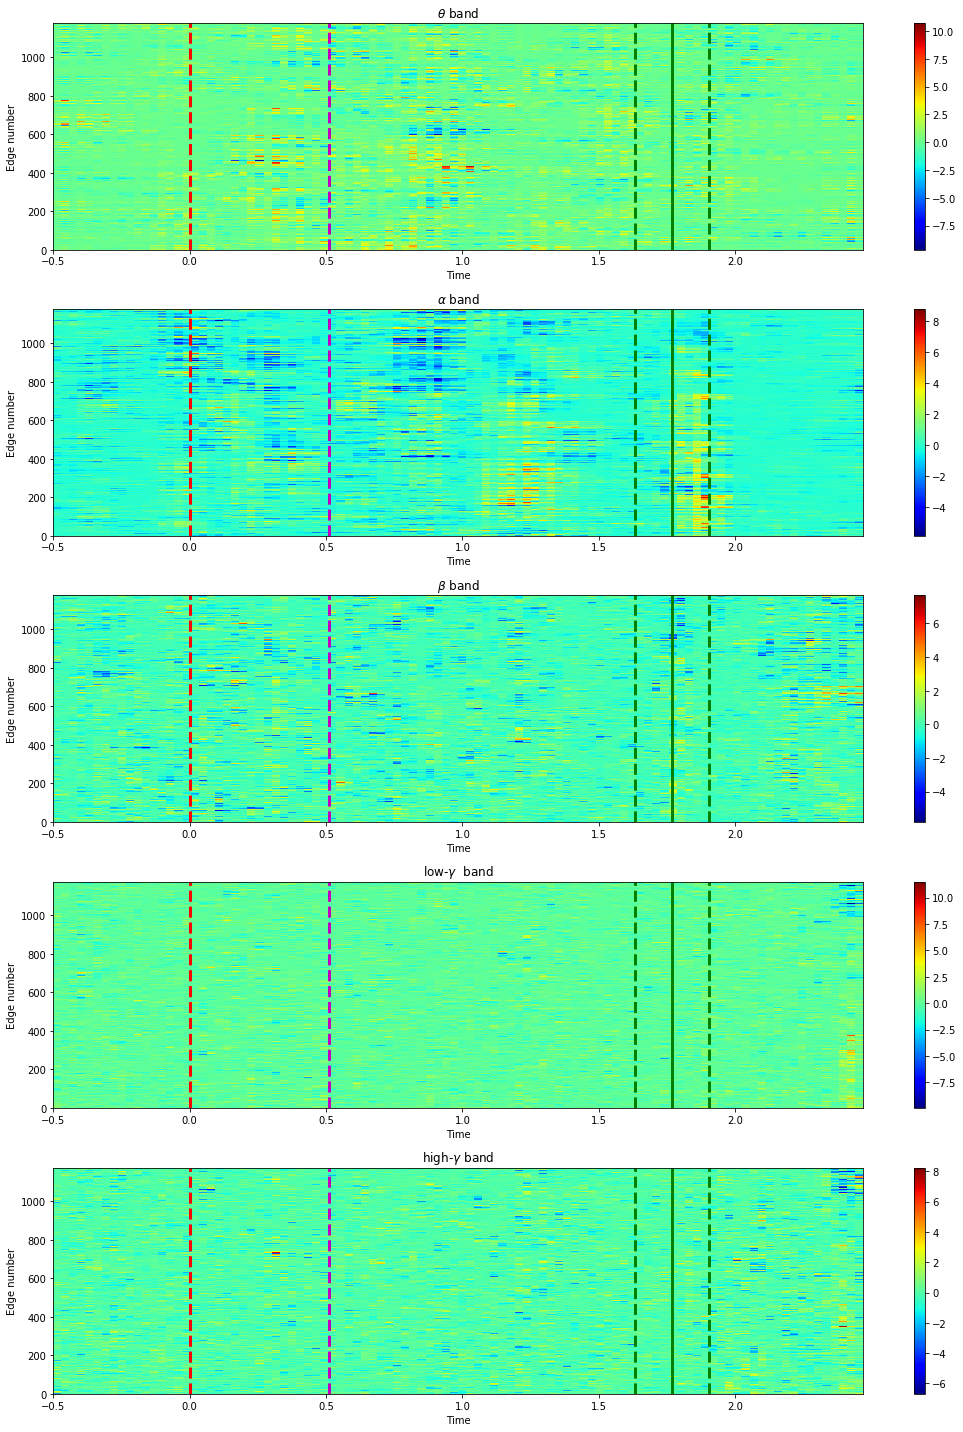

In [7]:
plt.figure(figsize=(15,20))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(Cij[i,:,10,:], aspect='auto', cmap='jet', origin='lower', 
               extent=[tarray[0],tarray[-1],1,1176], 
               )
    plt.vlines(0, 1,1176, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((ses.readinfo['t_cue_off']-ses.readinfo['t_cue_on']).mean()/1000, 
                   1,1176, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).mean()/1000, 
                       1,1176, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).mean()/1000-(ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).std()/1000, 
                       1,1176, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).mean()/1000+(ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).std()/1000, 
                       1,1176, linestyle='--', linewidth = 3, color = 'g')
    plt.title(band_names[i] + ' band')
    plt.ylabel('Edge number')
    plt.xlabel('Time')
    plt.colorbar()
plt.tight_layout()

#### Links' correlation time series averaged over trials

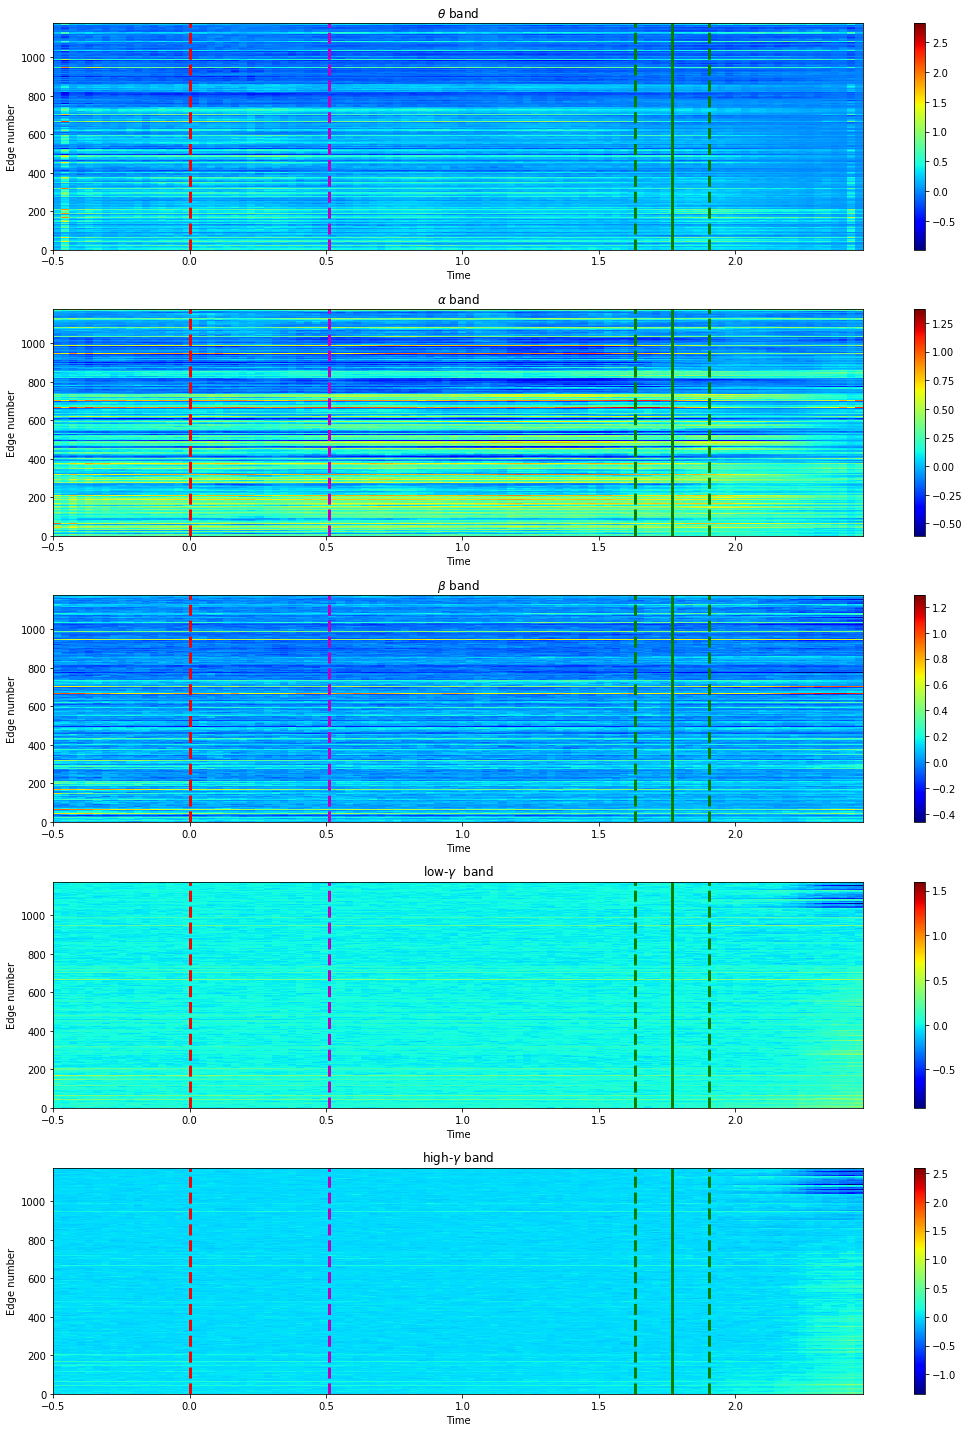

In [8]:
plt.figure(figsize=(15,20))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(Cij[i,:,:,:].mean(axis=1), aspect='auto', cmap='jet', origin='lower', 
               extent=[tarray[0],tarray[-1],1,1176], 
               )
    plt.vlines(0, 1,1176, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((ses.readinfo['t_cue_off']-ses.readinfo['t_cue_on']).mean()/1000, 
                   1,1176, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).mean()/1000, 
                       1,1176, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).mean()/1000-(ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).std()/1000, 
                       1,1176, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).mean()/1000+(ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).std()/1000, 
                       1,1176, linestyle='--', linewidth = 3, color = 'g')
    plt.title(band_names[i] + ' band')
    plt.ylabel('Edge number')
    plt.xlabel('Time')
    plt.colorbar()
plt.tight_layout()

In [9]:
Cij.shape

(5, 1176, 540, 100)

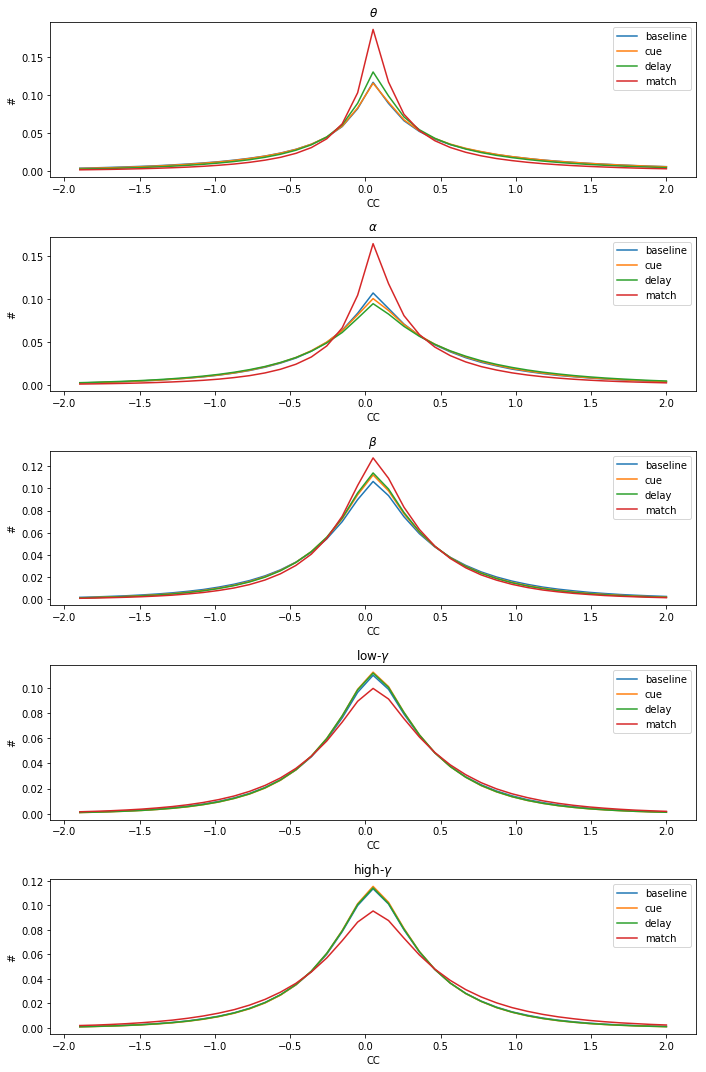

In [10]:
plt.figure(figsize=(10,15))
aux = Cij.reshape(len(bands), ses.readinfo['nP'], ses.readinfo['nT']*len(tarray))
for j in range(len(bands)):
    plt.subplot(len(bands), 1, j+1)
    for i in range(len(stages)):
        temp = aux[j,:,t_mask[i]].flatten(order='C')
        n,x = np.histogram(temp, bins = np.linspace(-2, 2,40))
        n   = n/n.sum()
        plt.plot(x[1:], n, label = stages[i])
    plt.legend()
    plt.xlabel('CC')
    plt.ylabel('#')
    plt.title(band_names[j])
    plt.tight_layout()

In [11]:
nbin = 100
HCij = np.zeros([len(bands), ses.readinfo['nP'], nbin-1])
for j in tqdm( range(len(bands)) ):
    bins = np.linspace(-5,5, nbin)
    for p in range(ses.readinfo['nP']):
        temp = aux[j,p,:]
        n, x = np.histogram(temp, bins = bins)
        n    = n/n.sum()
        HCij[j,p,:] = n

100%|██████████| 5/5 [00:22<00:00,  4.40s/it]


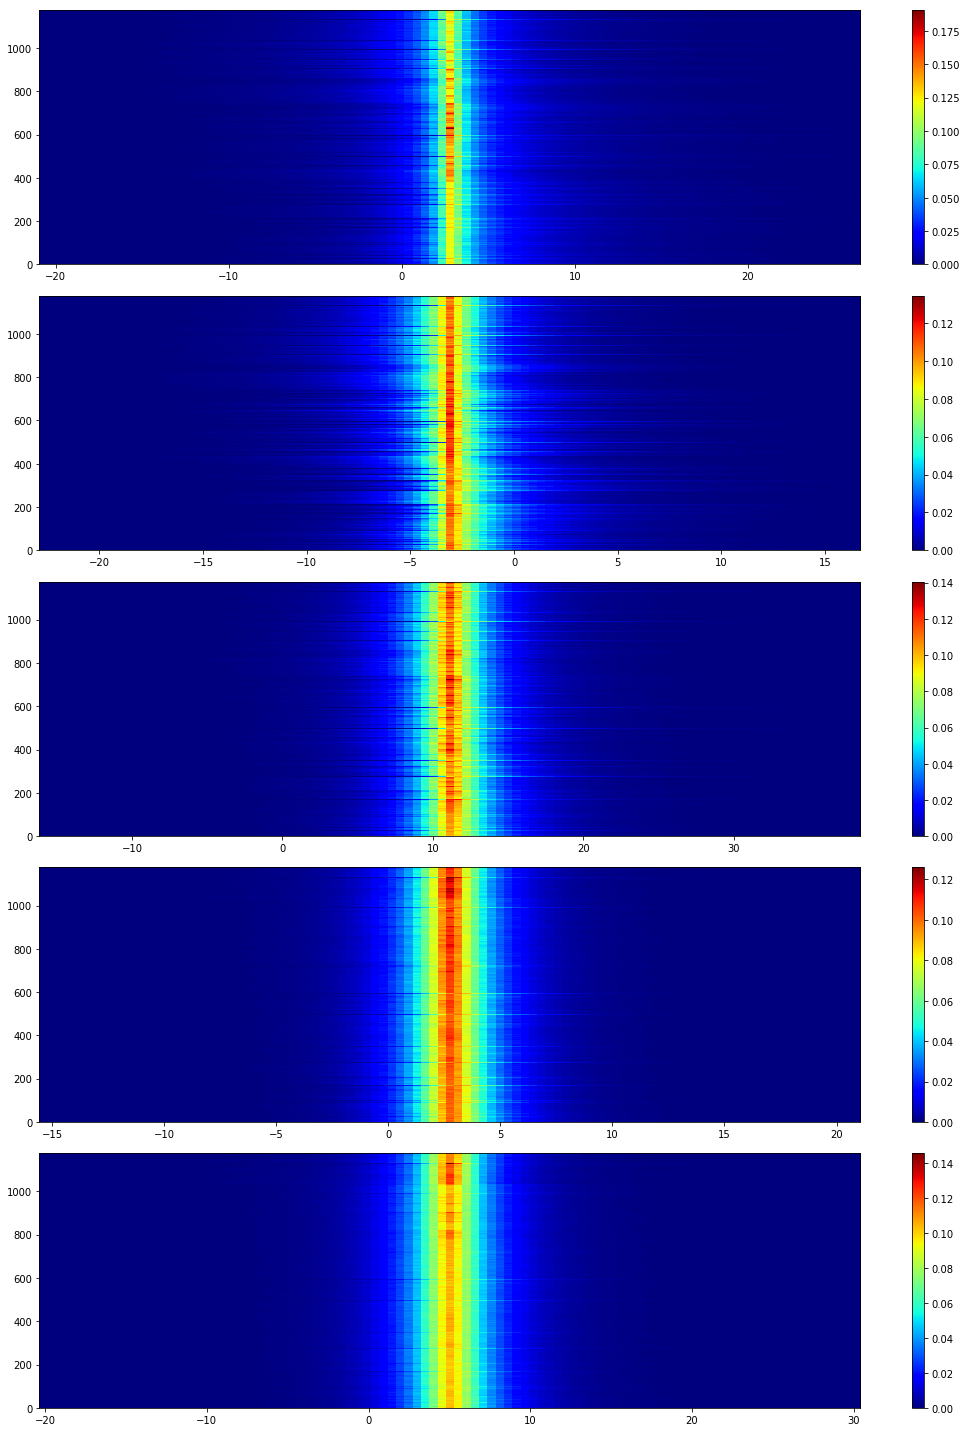

In [12]:
plt.figure(figsize=(15,20))
for i in range(len(bands)):
    bins = np.linspace(aux[i].min(), aux[i].max(), nbin)
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(HCij[i,:,:], aspect='auto', cmap='jet', origin='lower', 
               extent=[bins[0],bins[-1],0,ses.readinfo['nP']])
    plt.colorbar()
plt.tight_layout()

#### Overall recruitment probability

In [13]:
r = np.zeros([len(bands), ses.readinfo['nP']])
for i in tqdm( range(len(bands)) ):
    for p in range(ses.readinfo['nP']):
        temp   = aux[i,p,:]
        thr    = scipy.stats.mstats.mquantiles(temp, prob=0.8)
        #print(thr)
        #print(temp>thr)
        r[i,p] = np.sum(temp>temp.mean())/len(temp)

100%|██████████| 5/5 [00:22<00:00,  4.44s/it]


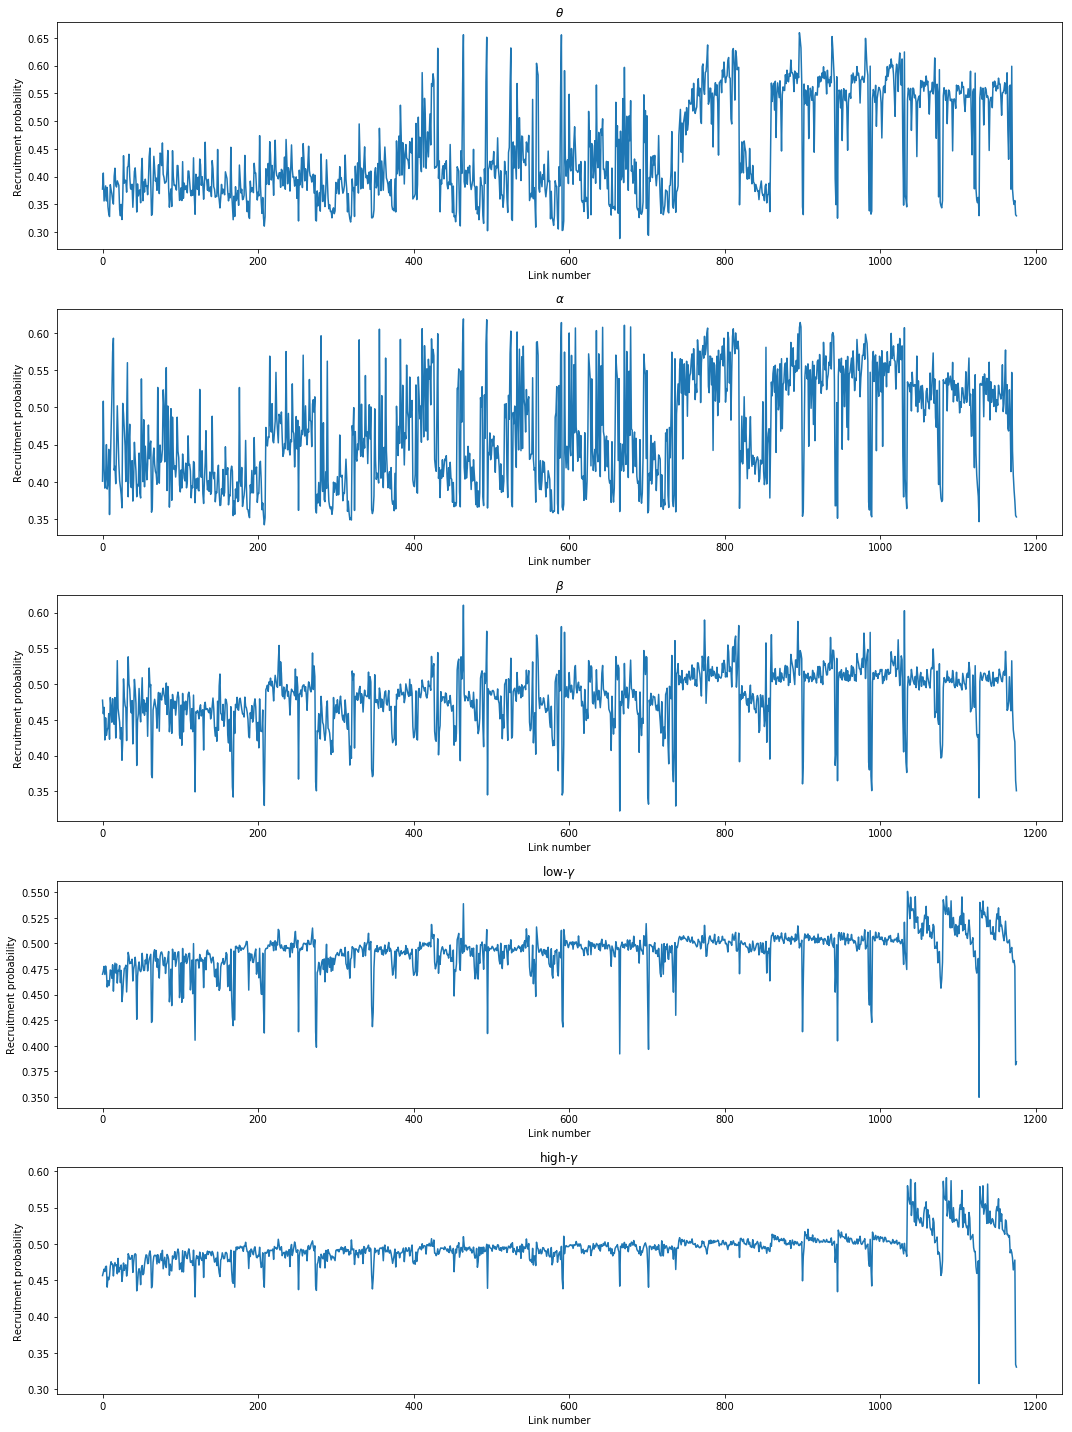

In [14]:
plt.figure(figsize=(15,20))
for i in range(len(bands)):
    plt.subplot(len(bands),1,i+1)
    plt.plot(r[i], label = band_names[i])
    plt.xlabel('Link number')
    plt.ylabel('Recruitment probability')
    plt.title(band_names[i])
plt.tight_layout()

#### Recruitment probability per task stage

In [15]:
r_s = np.zeros([len(bands), len(stages),ses.readinfo['nP']])
for i in tqdm( range(len(bands)) ):
    for s in range(len(stages)):
        for p in range(ses.readinfo['nP']):
            temp = aux[i,p,t_mask[s]]
            r_s[i,s,p] = np.sum(temp>temp.mean())/len(temp)

100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


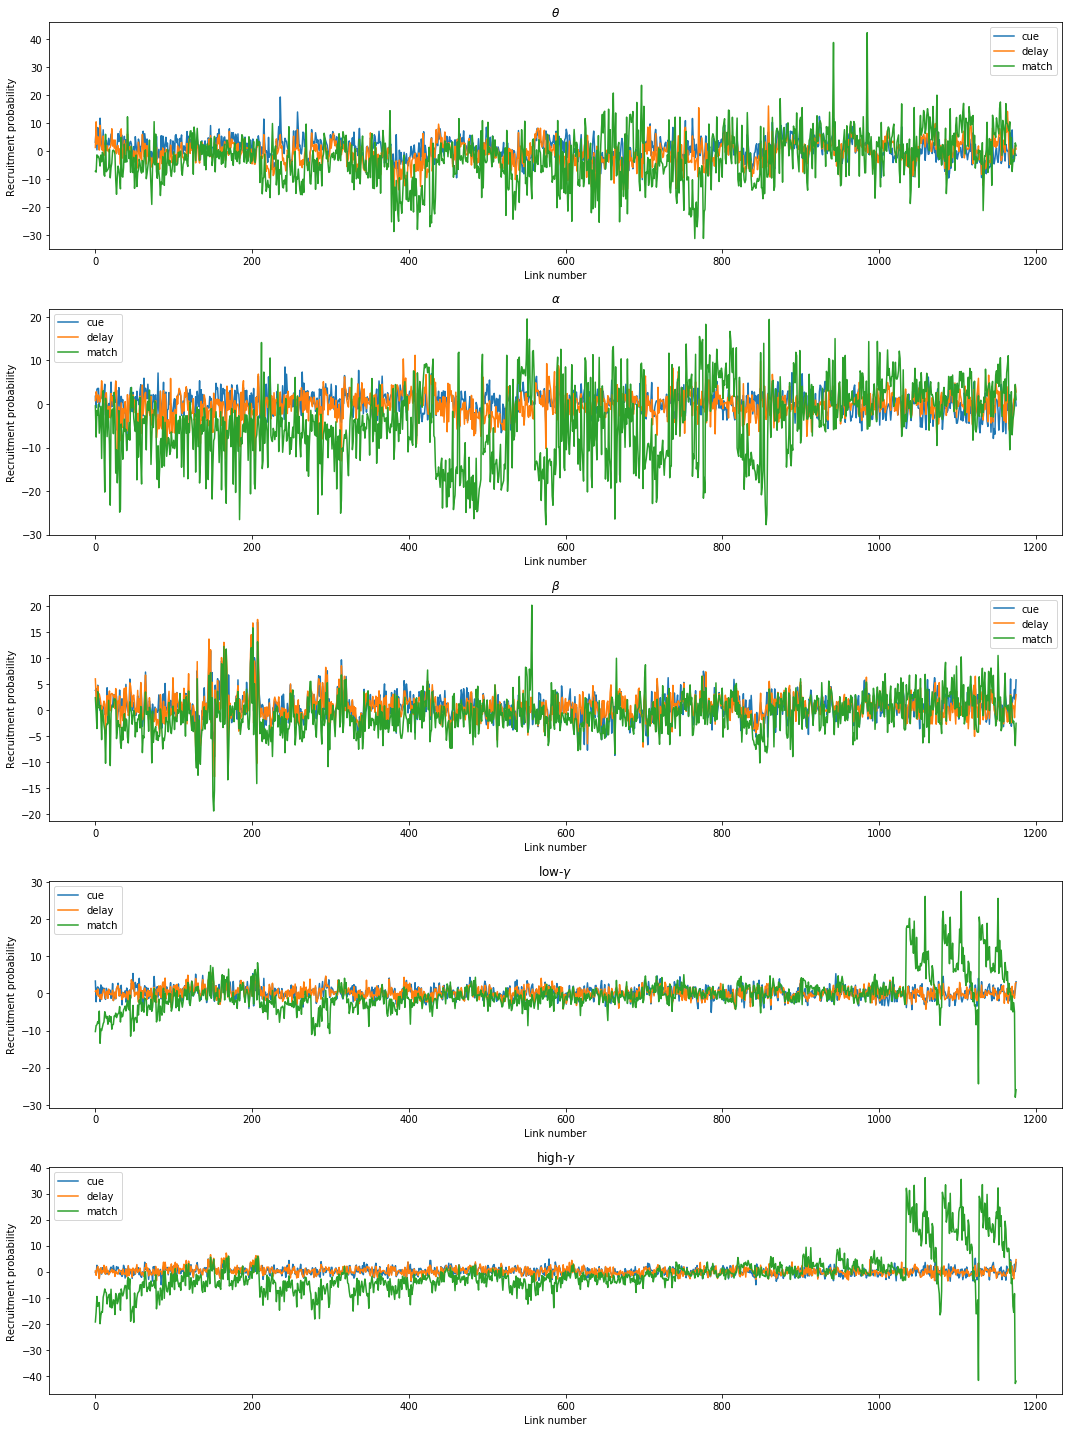

In [16]:
plt.figure(figsize=(15,20))
for i in range(len(bands)):
    plt.subplot(len(bands),1,i+1)
    for s in range(1, len(stages)):
        plt.plot(100*(r_s[i,s,:]-r_s[i,0,:])/r_s[i,0,:], label = stages[s])
    plt.legend()
    plt.xlabel('Link number')
    plt.ylabel('Recruitment probability')
    plt.title(band_names[i])
plt.tight_layout()

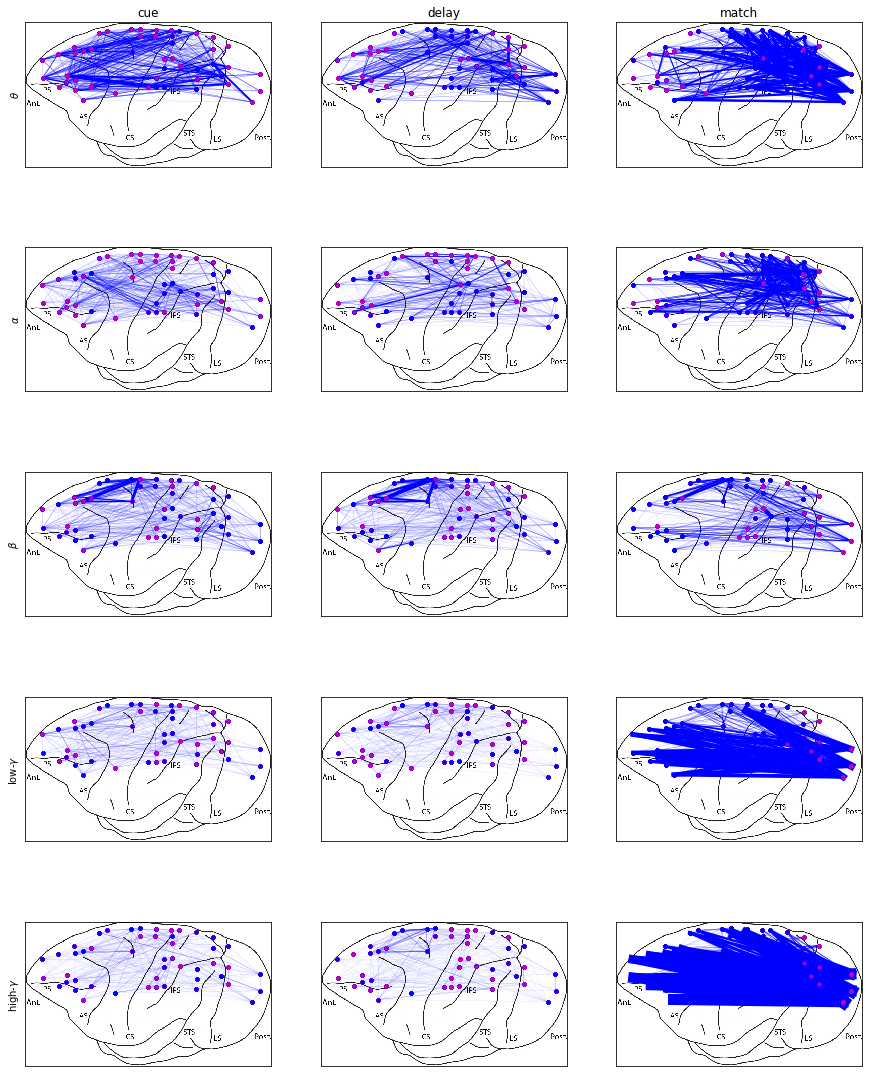

In [17]:
plt.figure(figsize=(15,20))
count = 1
for i in range(len(bands)):
    for s in range(1, len(stages)):
        plt.subplot(len(bands),len(stages)-1,count)
        aux = 100*(r_s[i,s,:]-r_s[i,0,:])/r_s[i,0,:]
        aux[aux<0]=0
        plot_edge_brain_sketch(ses.readinfo['pairs'], ses.readinfo['channels_labels'].astype(int), 
                               (.1*aux)**2)
        if i == 0: plt.title(stages[s])
        if s == 1: plt.ylabel(band_names[i])
        count += 1

In [18]:
P_ij = np.zeros([len(stages),len(bands),ses.readinfo['nC'],ses.readinfo['nC']])
for i in range(len(bands)):
    for s in range(1,len(stages)):
        for p in range(ses.readinfo['nP']):
            ch1, ch2 = ses.readinfo['pairs'][p,0], ses.readinfo['pairs'][p,1]
            P_ij[s-1,i,ch1,ch2] = P_ij[s-1,i,ch2,ch1] = 100*(r_s[i,s,p]-r_s[i,0,p])/r_s[i,0,p]

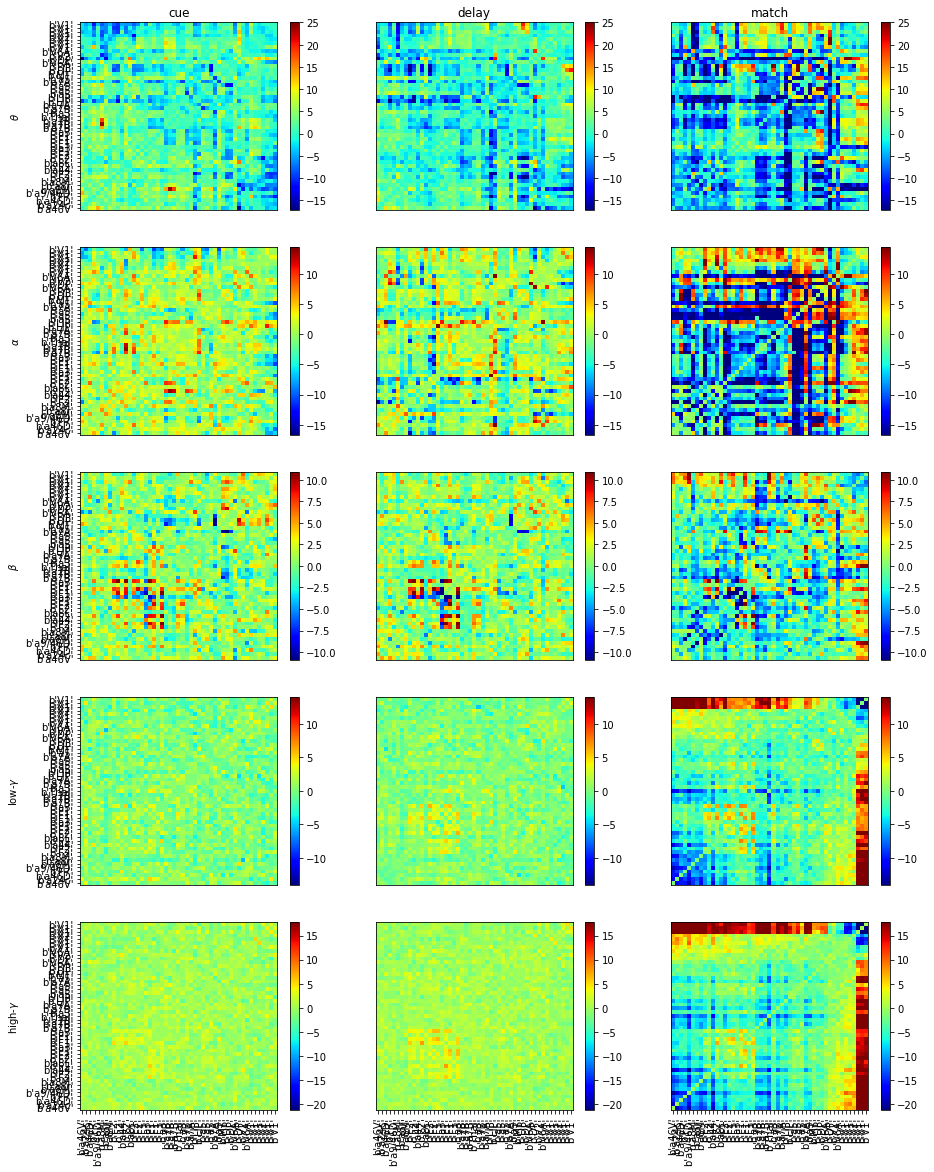

In [19]:
plt.figure(figsize=(15,20))
count = 1
for i in range(len(bands)):
    for s in range(len(stages)-1):
        plt.subplot(len(bands),len(stages)-1,count)
        plt.imshow(P_ij[s,i,:,:], aspect='auto', cmap='jet',origin='lower',
                   vmin=P_ij[:,i,:,:].min()/2, vmax=P_ij[:,i,:,:].max()/2)
        plt.colorbar()
        if i == 0: plt.title(stages[s+1])
        if s == 0: plt.ylabel(band_names[i])
        if i == 4: plt.xticks(range(49),ses.readinfo['areas'], rotation=90)
        else: plt.xticks([])
        if s == 0: plt.yticks(range(49),ses.readinfo['areas'])
        else: plt.yticks([])
        count += 1

#### Communities

In [119]:
# Adjacency matrix
aux = Cij.reshape(len(bands), ses.readinfo['nP'],ses.readinfo['nT']*len(tarray))
print(aux.shape)
A   = np.zeros([len(bands), ses.readinfo['nC'], ses.readinfo['nC'], ses.readinfo['nT']*len(tarray)])
for i in tqdm( range(len(bands)) ):
    for p in range(ses.readinfo['nP']):
        ch1, ch2 = ses.readinfo['pairs'][p,0], ses.readinfo['pairs'][p,1]
        A[i,ch1,ch2,:] = A[i,ch2,ch1,:] = aux[i,p,:]





  0%|          | 0/5 [00:00<?, ?it/s]

(5, 1176, 324000)






 20%|██        | 1/5 [00:02<00:11,  2.80s/it]



 40%|████      | 2/5 [00:05<00:08,  2.86s/it]



 60%|██████    | 3/5 [00:09<00:06,  3.23s/it]



 80%|████████  | 4/5 [00:14<00:03,  3.62s/it]



100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


In [ ]:
print(A.shape)

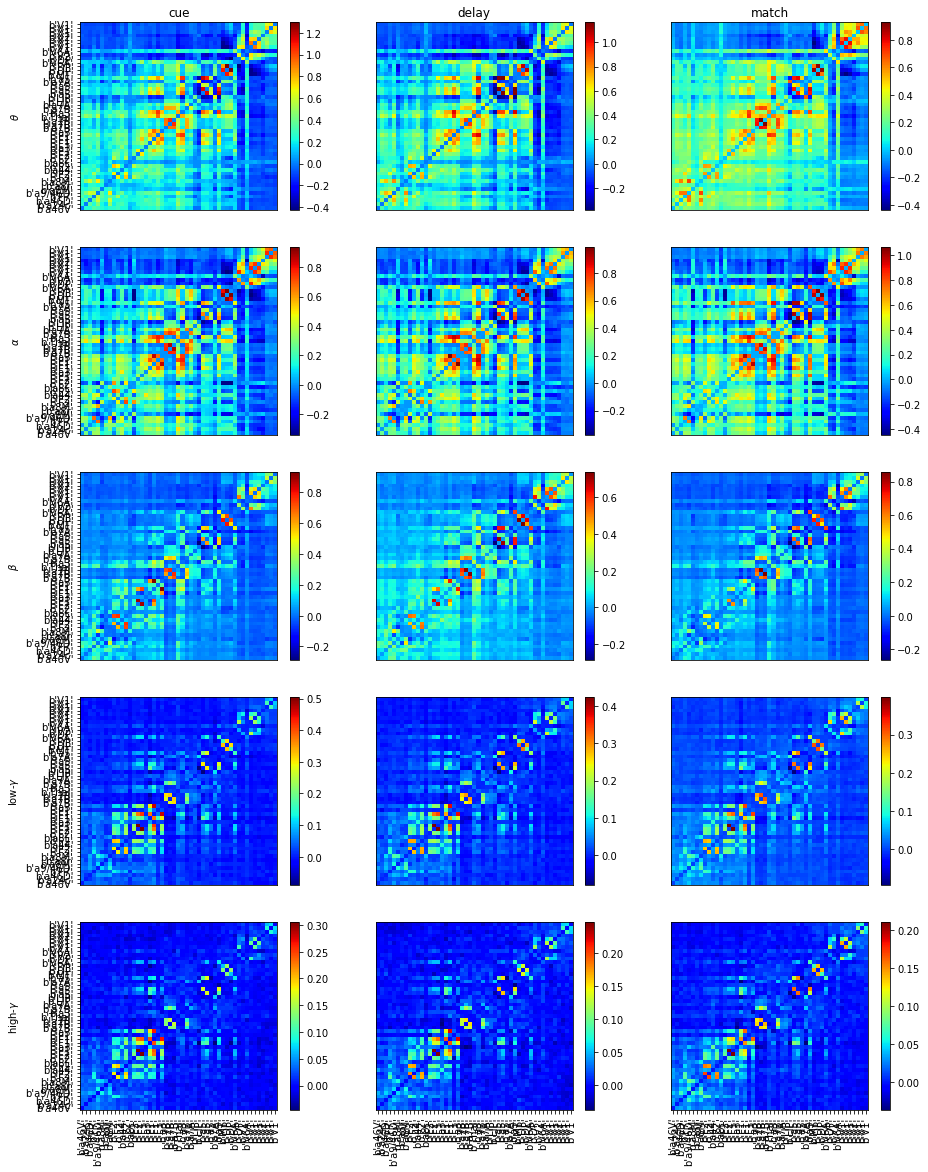

In [118]:
plt.figure(figsize=(15,20))
count = 1
for i in range(len(bands)):
    for s in range(len(stages)-1):
        plt.subplot(len(bands),len(stages)-1,count)
        plt.imshow(A[i,:,:,s], aspect='auto', cmap='jet',origin='lower')
        plt.colorbar()
        if i == 0: plt.title(stages[s+1])
        if s == 0: plt.ylabel(band_names[i])
        if i == 4: plt.xticks(range(49),ses.readinfo['areas'], rotation=90)
        else: plt.xticks([])
        if s == 0: plt.yticks(range(49),ses.readinfo['areas'])
        else: plt.yticks([])
        count += 1

In [14]:
mu = None
CV = np.zeros([P_ij.shape[0], P_ij.shape[1], len(stages)])
for i in tqdm( range(P_ij.shape[0]) ):
    for s in range(len(stages)):
        idx         = t_mask[s].reshape(ses.readinfo['nT'], len(tarray))[i,:]
        #CV[i,:,j,s] = np.apply_along_axis(count_activations, 0, raster[i,:,j,idx])[2,:]
        aux = P_ij[i,:,idx]#np.apply_along_axis(smooth, 0, S_avg[i,:,j,idx])
        aux[aux<0]=0
        CV[i,:,s] = aux.std(axis=0 ) / aux.mean(axis=0)
        #aux = S_avg[i,:,j,idx]/S_avg[i,:,j,idx].sum(axis=0)
        #Hs  = np.sum( aux.T*np.log2(aux.T), axis=1 )/ np.log2(aux.shape[0])
        #CV[i,:,j,s] = Hs

  4%|▎         | 19/540 [00:00<00:02, 188.72it/s]/opt/ohpc/pub/libs/gnu8/python/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|██████████| 540/540 [00:02<00:00, 187.10it/s]


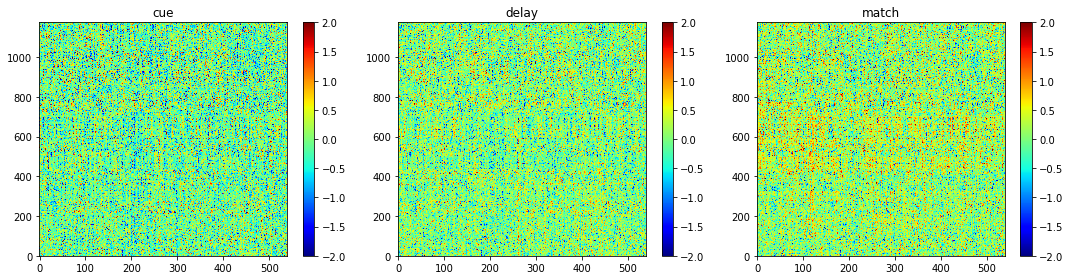

In [53]:
plt.figure(figsize = (20,4))
count = 1 
for s in range(1,len(stages)):
    plt.subplot(1, len(stages), count)
    plt.imshow(CV[:,:,s].T-CV[:,:,0].T, aspect='auto', cmap='jet', origin='lower', vmin=-2, vmax=2)
    plt.colorbar()
    count += 1
    plt.title(stages[s])
plt.tight_layout()

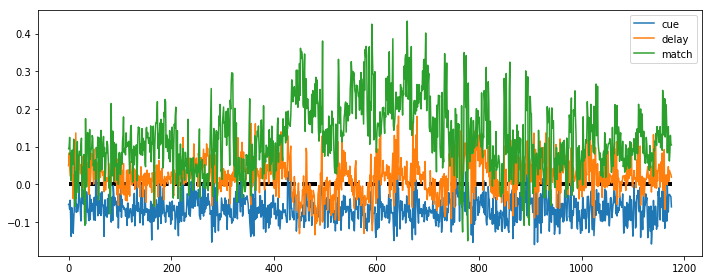

In [54]:
plt.figure(figsize = (10,4))
for s in range(1,len(stages)):
    plt.plot(np.nanmean( CV[:,:,s], axis=0)-np.nanmean( CV[:,:,0], axis=0), label = stages[s])
plt.legend()   
plt.tight_layout()
plt.hlines(0, 0, ses.readinfo['nP'], linestyle='--', lw = 4)

In [55]:
raster = np.zeros_like(P_ij)
for T in range(ses.readinfo['nT']):
    thr = scipy.stats.mstats.mquantiles(P_ij[T,:,:], prob=.80, axis=-1)
    raster[T,:,:]= P_ij[T,:,:]>thr

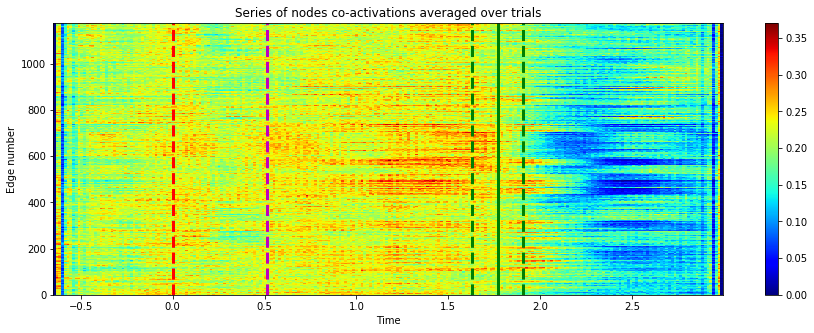

In [56]:
plt.figure(figsize=(15,5))
plt.imshow(raster.mean(axis=0), aspect='auto',cmap='jet', origin='lower',
           extent=[tarray[0],tarray[-1],0,1176])
plt.vlines(0, 0,1176, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((ses.readinfo['t_cue_off']-ses.readinfo['t_cue_on']).mean()/1000, 
               0,1176, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).mean()/1000, 
                   0,1176, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).mean()/1000-(ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).std()/1000, 
                   0,1176, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).mean()/1000+(ses.readinfo['t_match_on']-ses.readinfo['t_cue_on']).std()/1000, 
                   0,1176, linestyle='--', linewidth = 3, color = 'g')
plt.title('Series of nodes co-activations averaged over trials')
plt.ylabel('Edge number')
plt.xlabel('Time')
plt.colorbar()

In [57]:
print(raster.shape)

(540, 1176, 244)


### eFC

In [65]:
nP       = int( scipy.special.comb(ses.readinfo['nP'], 2) )
i, j     = np.tril_indices(ses.readinfo['nP'], k = -1)
pairs    = np.array([j,i]).T

In [66]:
r = raster.swapaxes(0,1).reshape(ses.readinfo['nP'], ses.readinfo['nT']*len(tarray))

In [62]:
Pe_ij = np.zeros([ses.readinfo['nP'], ses.readinfo['nP'], len(stages)])

In [63]:
for s in tqdm( range(len(stages)) ):
    aux = r[:,t_mask[s]]
    L   = np.sum(t_mask[s])
    for i, j in pairs:
        Pe_ij[i,j,s] = Pe_ij[j,i,s] = np.dot(aux[i], aux[j]) / L

100%|██████████| 4/4 [03:50<00:00, 57.56s/it]


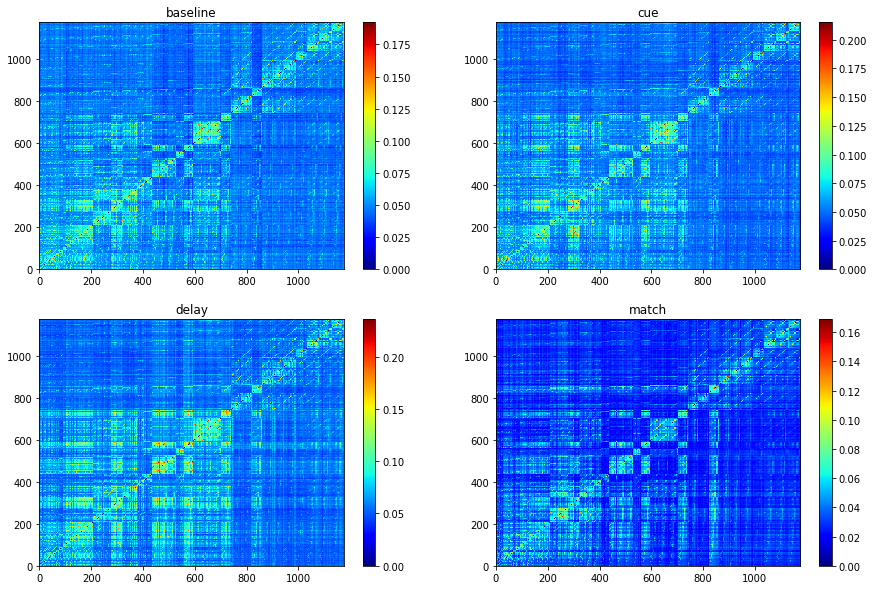

In [67]:
plt.figure(figsize=(15,10))
for i in range(len(stages)):
    plt.subplot(2,2,i+1)
    plt.imshow(Pe_ij[:,:,i], aspect = 'auto', cmap = 'jet', origin = 'lower')
    plt.title(stages[i])
    plt.colorbar()

In [38]:
aux[j].shape

(1176,)

In [33]:
pairs.shape

(690900, 2)

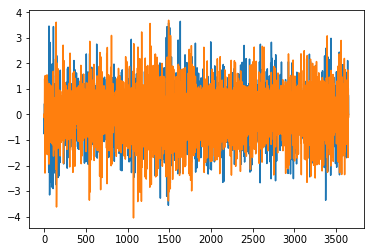

In [18]:
plt.plot(Z[0,0])
plt.plot(Z[0,1])


In [18]:
Z = scipy.stats.zscore(ses.data, axis=-1)

In [19]:
X_1 = Z[0,0,:]
X_2 = Z[0,1,:]

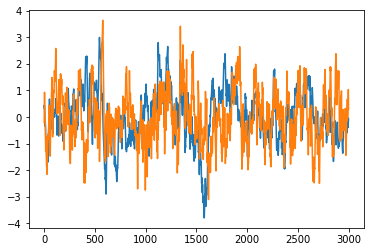

In [20]:
plt.plot(X_1)
plt.plot(X_2)

In [21]:
W = 30

In [22]:
r,c = int(X_1.shape[-1]/W), W
X_1 = X_1.reshape((r,c))
X_2 = X_2.reshape((r,c))

In [23]:
FC = np.sum(X_1*X_2, axis=1)/W

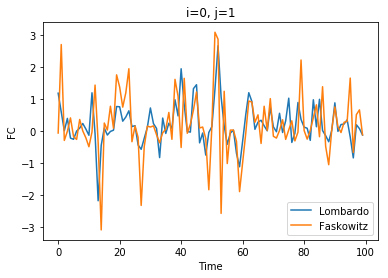

In [25]:
plt.plot(FC)
plt.plot(Cij[0,0,0,:])
plt.ylabel('FC')
plt.xlabel('Time')
plt.title('i=0, j=1')
plt.legend(['Lombardo', 'Faskowitz'])

In [124]:
FC.shape

(100,)

In [34]:
lombardo.lombardo

<function GDa.fc.lombardo.lombardo(x_i, x_j, W)>

In [10]:
Cij.shape

(4, 1176, 540, 100)

In [61]:
r

array([[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]])

In [63]:
temp.shape

(324000,)

In [64]:
thr

array([0.5021257])

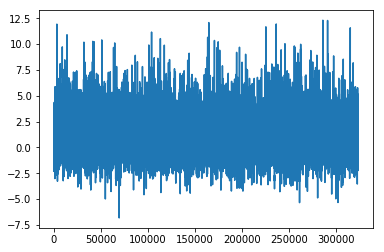

In [68]:
plt.plot(temp)

In [70]:
thr[0]

1.0433984948738682

In [95]:
ses.readinfo['nC']

49

In [ ]:
len(tarray)